# [The ETL Character Database](http://etlcdb.db.aist.go.jp)

- `ETL Character database` is a collection of images of about 1.2 million hand-written and machine-printed numerals, symbols, Latin alphabets and Japanese characters and compiled in 9 datasets (ETL-1 to ETL-9).

## ETL-1

- Format of a record:

index | byte range | # of bytes | type | contents
----- | ---------- | ---------- | ---- | --------
0 | 1-2 | 2 | integer | data index (>= 1)
1 | 3-4 | 2 | ascii | character name (e.g. `0`, `A`, `$`, `KA`)
2 | 5-6 | 2 | integer | sheet index (>= 1)
3 | 7 | 1 | binary | character code ([JIS X 0201](https://en.wikipedia.org/wiki/JIS_X_0201))
4 | 8 | 1 | binary | character code ([EBCDIC](https://en.wikipedia.org/wiki/EBCDIC))
5 | 9 | 1 | integer | quality of character image (0: clean, 1, 2, 3)
6 | 10 | 1 | integer | quality of character group (0: clean, 1, 2)
7 | 11 | 1 | integer | gender of writer (1: male, 2: female) (JIS X 0303)
8 | 12 | 1 | integer | age of writer
9 | 13-16 | 4 | integer | serial data index (>= 1)
10 | 17-18 | 2 | integer | industry classification code (JIS X 0403)
11 | 19-20 | 2 | integer | occupation classification code (JIS X 0404)
12 | 21-20 | 2 | integer | data of sheet gathering (19)YYMM
13 | 23-24 | 2 | integer | date of scan (19)YYMM
14 | 25 | 1 | integer | y coordinate of scan position on sheet (>= 1)
15 | 26 | 1 | integer | x coordinate of scan position on sheet (>= 1)
16 | 27 | 1 | integer | minimum intensity level (0-255)
17 | 28 | 1 | integer | maximum scanned level (0-255)
18 | 29-30 | 2 | integer | (undefined)
19 | 31-32 | 2 | integer | (undefined)
20 | 33-2048 | 2016 | packed | 16 gray level (4bit/pixel) image data. 64x63 (x-axis, y-axis) = 4032 pixel
21 | 2049-2052 | 4 | integer | (uncertain)

- Contents of files:

filename | categories | # catagories | sheets | # sheets | # records | note
-------- | ---------- | ------------ | ------ | -------- | --------- | ----
ETL1C-01 | 01234567 | 8 | 1001-2960 | 1445 | 11560 |
ETL1C-02 | 89ABCDEF | 8 | 1001-2960 | 1445 | 11560 |
ETL1C-03 | GHIJKLMN | 8 | 1001-2960 | 1445 | 11560 |
ETL1C-04 | OPQRSTUV | 8 | 1001-2960 | 1445 | 11560 |
ETL1C-05 | WXYZ¥+-* | 8 | 1001-2960 | 1445 | 11560 |
ETL1C-06 | /=()・,␣’ | 8 | 1001-2960 | 1445 | 11560 |
ETL1C-07 | アイウエオカキク | 8 | 1001-2960 | 1411 | 11288 |
ETL1C-08 | ケコサシスセソタ | 8 | 1001-2960 | 1411 | 11288 |
ETL1C-09 | チツテトナニヌネ | 8 | 1001-2960 | 1411 | 11287 | ナ on sheet 2672 is missing
ETL1C-10 | ノハヒフヘホマミ | 8 | 1001-2960 | 1411 | 11288 |
ETL1C-11 | ムメモヤイユエヨ | 8 | 1001-2960 | 1411 | 11288 |
ETL1C-12 | ラリルレロワヰウ | 8 | 1001-2960 | 1411 | 11287 | リ on sheet 2708 is missing
ETL1C-13 | ヱヲン | 3 | 1001-2960 | 1411 | 4233 |


- Sample code for extracting a record from a file

In [1]:
import os
import re
import struct

import numpy as np
import cv2
import matplotlib.pyplot as plt

#! pip install pillow

from PIL import Image, ImageEnhance # from pillow package

### `unpack` string `>H2sH6BI4H4B4x2016s4x`

- `>` : use standard size (not platform depend)

format | C type | python type | tuple index | content
------ | ------ | ----------- | ----------- | -------
`H` | unsigned short | integer | 0 | character index
`2s` | char[2] | bytes | 1 | character name (e.g. `0`, `A`, `$`, `KA`)
`H` | unsign short | integer | 2 | sheet index
`6B`  | unsigned char[6] | integer[6] | 3-8 | refer to 3-6 from the `record format table`
`I` | unsigned int | integer | 9
`4H` | unsigned short[4] | integer[4] | 10-13
`4B` | unsigned char[4] | integer[4] | 14-17
`4x` | pad byte | no value | None | None
`2016s` | char[2016] | bytes | 18 | the image data
`4x` | pad byte | no value | None | None

- For more information about `unpack` visit [here](https://docs.python.org/3.7/library/struct.html#format-characters).

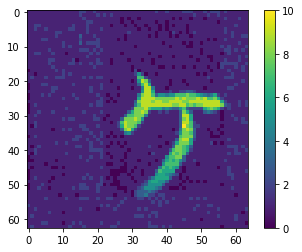

In [2]:
filename = 'ETL1/ETL1C_08'
with open(filename, 'rb') as f:
    skip = 23
    f.seek(skip * 2052)
    s = f.read(2052)
    r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s) # r is a tuple with the data as shown in the above table
    iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4) # use pillow to decode image
    img = np.array(iF, dtype=np.float) # convert to numpy array
    plt.imshow(img)
    plt.colorbar()
    plt.show()

In [3]:
def unpack_datasets(path, unpack_path):
    f = open(path, 'rb')
    while True:
        s = f.read(2052)

        if not len(s) == 2052:
            print('Reach EOF, remain {} bytes unread'.format(len(s)))
            break;
        
        record = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
        
        # record index at index 0
        index = record[0]

        # label at index 1
        label = record[1].decode('ascii')

        if ' ' in label:
            label = label.replace(' ', '')
        # image at index 18
        iF = Image.frombytes('F', (64, 63), record[18], 'bit', 4)
        np_img = (np.array(iF, dtype=np.float) / 15.0 * 255).astype(np.uint8)

        cat_path = os.path.join(unpack_path, label)

        if not os.path.exists(cat_path):
            os.makedirs(cat_path)

        record_path = os.path.join(cat_path, '{}.png'.format(index))
    
        if not os.path.exists(record_path):
            cv2.imwrite(record_path, np_img)
    f.close()
    
def unpack_etl1_datasets(etl1_path, unpack_path):
    # we only need the katakana characters
    skip_etls = [
        'ETL1C_01',
        'ETL1C_02',
        'ETL1C_03',
        'ETL1C_04',
        'ETL1C_05',
        'ETL1C_06',
    ]
    if not os.path.exists(etl1_path):
        print('Invalid path')
    etl1_files = os.listdir(etl1_path)
    for etl in etl1_files:
        if not re.search('ETL1C_\d\d', etl) == None:
            if etl in skip_etls:
                continue
            etl_path = os.path.join(etl1_path, etl)
            unpack_datasets(etl_path, unpack_path)

In [4]:
unpack_etl1_datasets('./ETL1/', 'etlcb_01_dataset')

Reach EOF, remain 0 bytes unread
Reach EOF, remain 0 bytes unread
Reach EOF, remain 0 bytes unread
Reach EOF, remain 0 bytes unread
Reach EOF, remain 0 bytes unread
Reach EOF, remain 0 bytes unread
Reach EOF, remain 0 bytes unread
